In [1]:
import pandas as pd
import scanpy as sc
import anndata
import scanorama
import scipy.sparse as ss
import matplotlib.pyplot as plt
import seaborn as sns
from ALLCools.plot import *
import pathlib
from cemba_data.tools.integration.utilities import calculate_direct_confusion

%matplotlib inline

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Parameters

In [2]:
mc_adata_path = 'Markers/mc.cluster_markers.h5ad'
atac_adata_path = 'Markers/atac.pseudo_cell.cluster_markers.h5ad'

# scanorama
scanorama_dim = 30
sigma = 100
alpha = 0
knn = 20

# clustering
k = 30
n_pcs = 20
n_jobs=40

In [20]:
# Parameters
scanorama_dim = 30
sigma = 100
alpha = 0
knn = 20
k = 30
n_pcs = 11
n_jobs = 40


In [4]:
output_dir = 'Integration'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

In [5]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

## Load Data

### mC

In [6]:
mc_adata = anndata.read_h5ad(mc_adata_path)
mc_cell_tidy_data = mc_adata.obs.copy()

In [7]:
mc_adata

AnnData object with n_obs × n_vars = 8167 × 567 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor', 'Replicate'
    var: 'chrom', 'start', 'end'

### atac 

In [8]:
atac_adata = anndata.read_h5ad(atac_adata_path)
atac_cell_tidy_data = atac_adata.obs.copy()

In [9]:
atac_cell_tidy_data.shape

(8096, 2)

In [ ]:
total_df = pd.DataFrame(atac_adata.X.todense(),
                        index=atac_adata.obs_names,
                        columns=atac_adata.var_names)
cluster_center = total_df.groupby(atac_adata.obs['SubType']).mean()

In [ ]:
atac_adata = anndata.AnnData(cluster_center.values,
                             obs=pd.DataFrame([], index=cluster_center.index),
                             var=pd.DataFrame([], index=cluster_center.columns))
atac_adata

## Preprocess

### Union

In [10]:
union = atac_adata.var_names & mc_adata.var_names

In [11]:
print(union.size, 'genes in common')

295 genes in common


### atac scale

In [12]:
atac_adata = atac_adata[:, union].copy()

In [13]:
sc.pp.scale(atac_adata)

### Reverse mC and scale

In [14]:
mc_adata = mc_adata[:, union].copy()
mc_adata.X = mc_adata.X.max() - mc_adata.X
sc.pp.scale(mc_adata)

## Integration

In [15]:
import scanorama
results = scanorama.correct_scanpy([mc_adata, atac_adata],
                                   metric='angular',
                                   dimred=scanorama_dim,
                                   sigma=sigma,
                                   alpha=alpha,
                                   knn=knn)
mc_adata, atac_adata = results

Found 295 genes among all datasets
[[0.         0.41576087]
 [0.         0.        ]]
Processing datasets (0, 1)


In [16]:
mc_adata.obs['Modality'] = 'mC'
atac_adata.obs['Modality'] = 'atac'

In [17]:
adata = anndata.AnnData(X=ss.vstack([mc_adata.X, atac_adata.X]),
                       obs=pd.DataFrame([], index=pd.Index(mc_adata.obs_names.tolist() \
                                                           + atac_adata.obs_names.tolist())),
                       var=pd.DataFrame([], index=union))
adata.obs['Modality'] = mc_adata.obs['Modality'].tolist(
) + atac_adata.obs['Modality'].tolist()

## Clustering Routine

In [18]:
sc.tl.pca(adata)

... storing 'Modality' as categorical


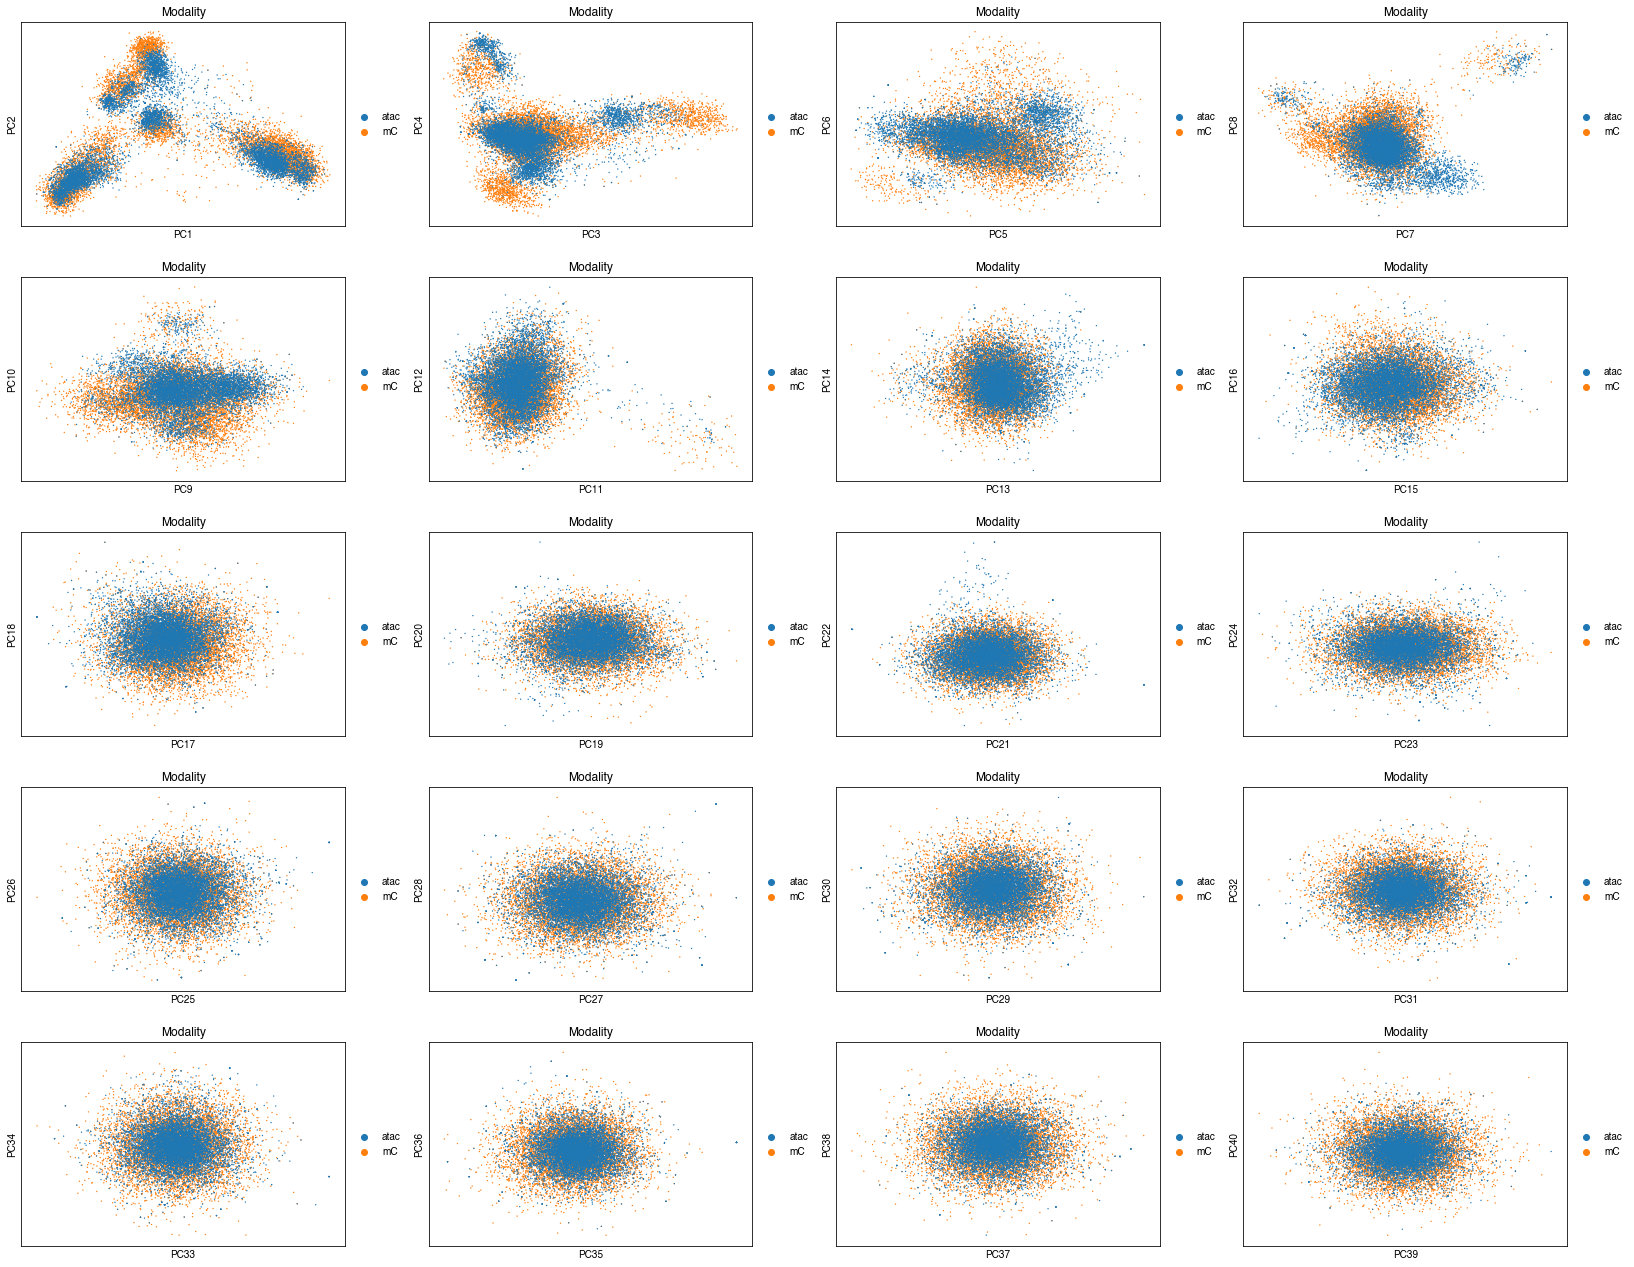

In [19]:
sc.pl.pca(adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16',
              '17,18', '19,20', '21,22', '23,24', '25,26', '27,28', '29,30',
              '31,32', '33, 34', '35, 36', '37, 38', '39, 40'
          ],
          color='Modality')

In [21]:
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=n_pcs)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata, n_jobs=n_jobs)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../../miniconda3/envs/clustering/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive

In [22]:
records = [adata.obs]
for coord in ['umap', 'pca', 'tsne']:
    temp_df = pd.DataFrame(adata.obsm[f'X_{coord}'][:, :2],
                           index=adata.obs_names,
                           columns=[f'{coord}_0', f'{coord}_1'])
    mc_cell_tidy_data[f'agg{coord}_0'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 0], index=adata.obs_names)
    mc_cell_tidy_data[f'agg{coord}_1'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 1], index=adata.obs_names)
    atac_cell_tidy_data[f'agg{coord}_0'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 0], index=adata.obs_names)
    atac_cell_tidy_data[f'agg{coord}_1'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 1], index=adata.obs_names)
    records.append(temp_df)
cell_tidy_data = pd.concat(records, axis=1)

In [23]:
atac_cell_tidy_data = cell_tidy_data[cell_tidy_data['Modality'] == 'atac'].copy()
atac_cell_tidy_data['SubType'] = atac_cell_tidy_data.index

In [24]:
mc_cell_tidy_data['co_cluster'] = pd.Series(adata.obs['leiden'],
                                            index=adata.obs_names)
atac_cell_tidy_data['co_cluster'] = pd.Series(adata.obs['leiden'],
                                             index=adata.obs_names)

## plot

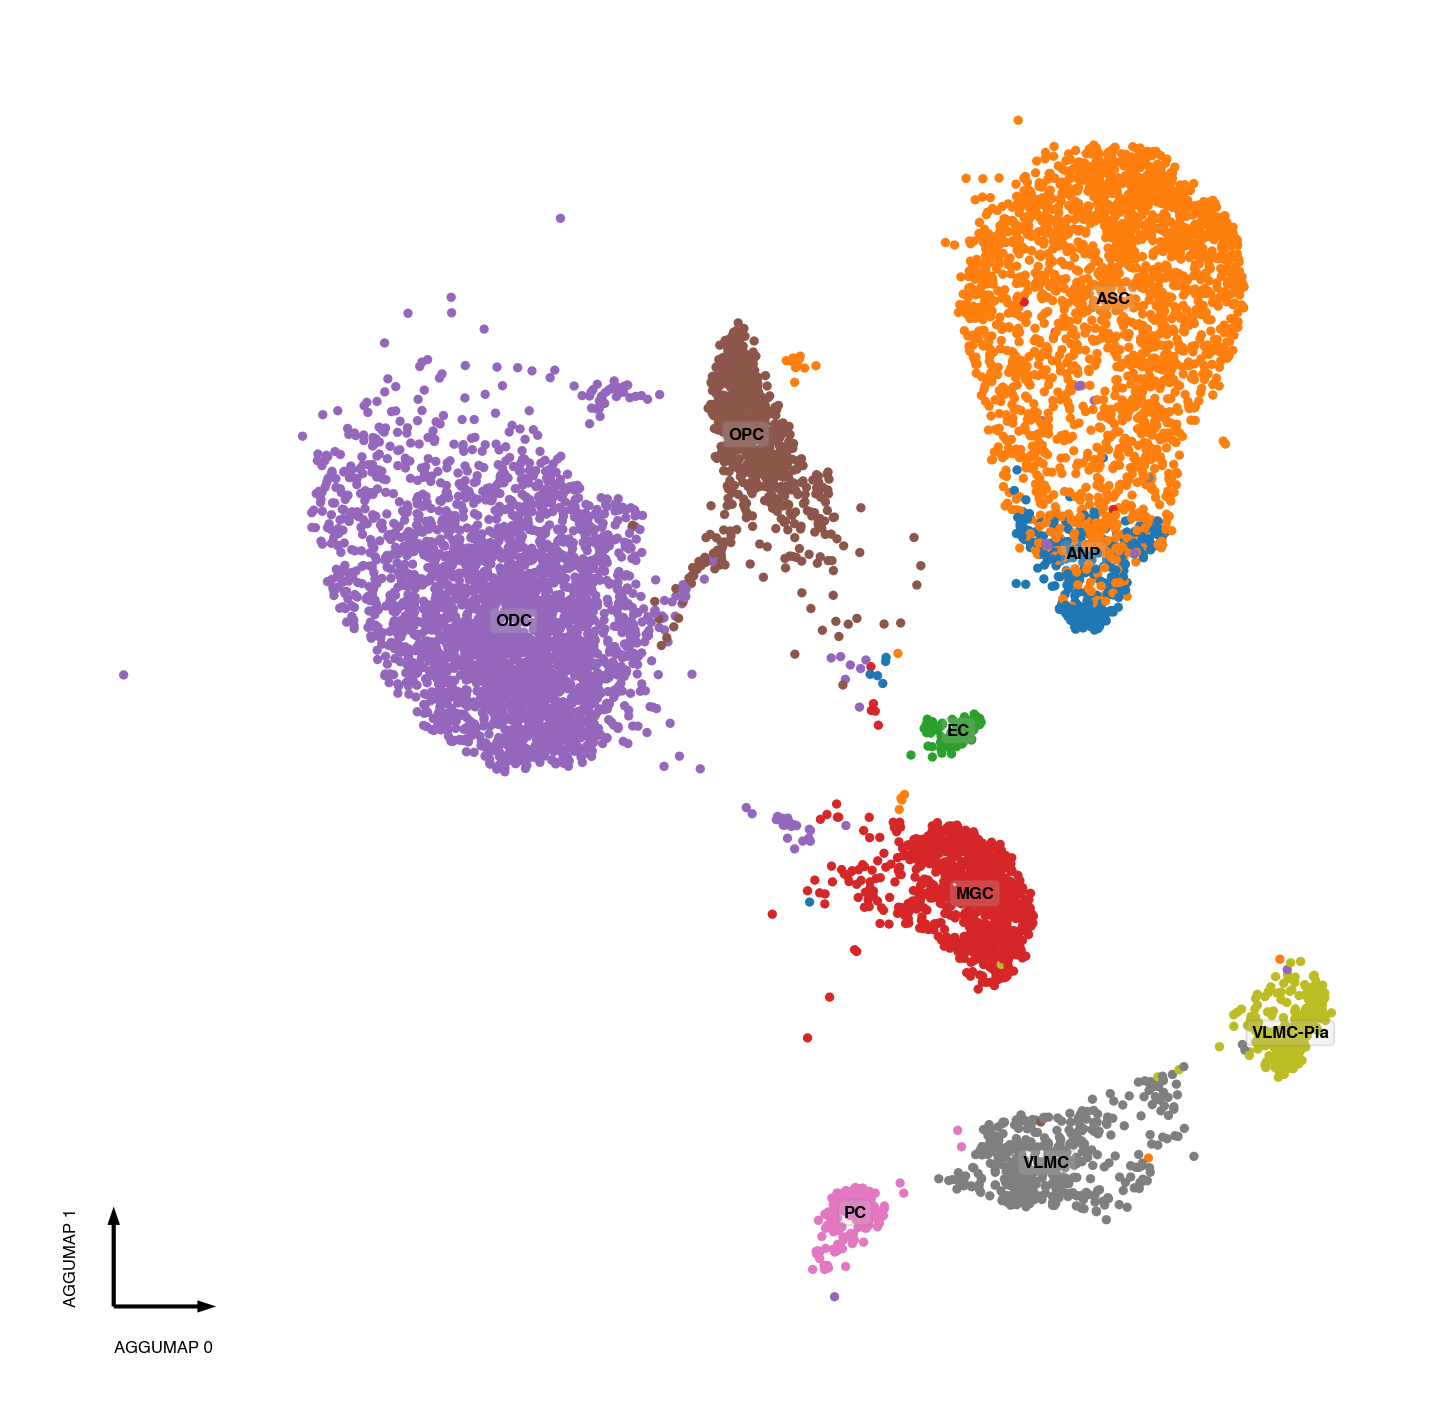

In [25]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=mc_cell_tidy_data,
                    hue='MajorType',
                    coord_base='aggumap',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='MajorType',
                    text_anno_kws=dict(fontsize=4))
pass

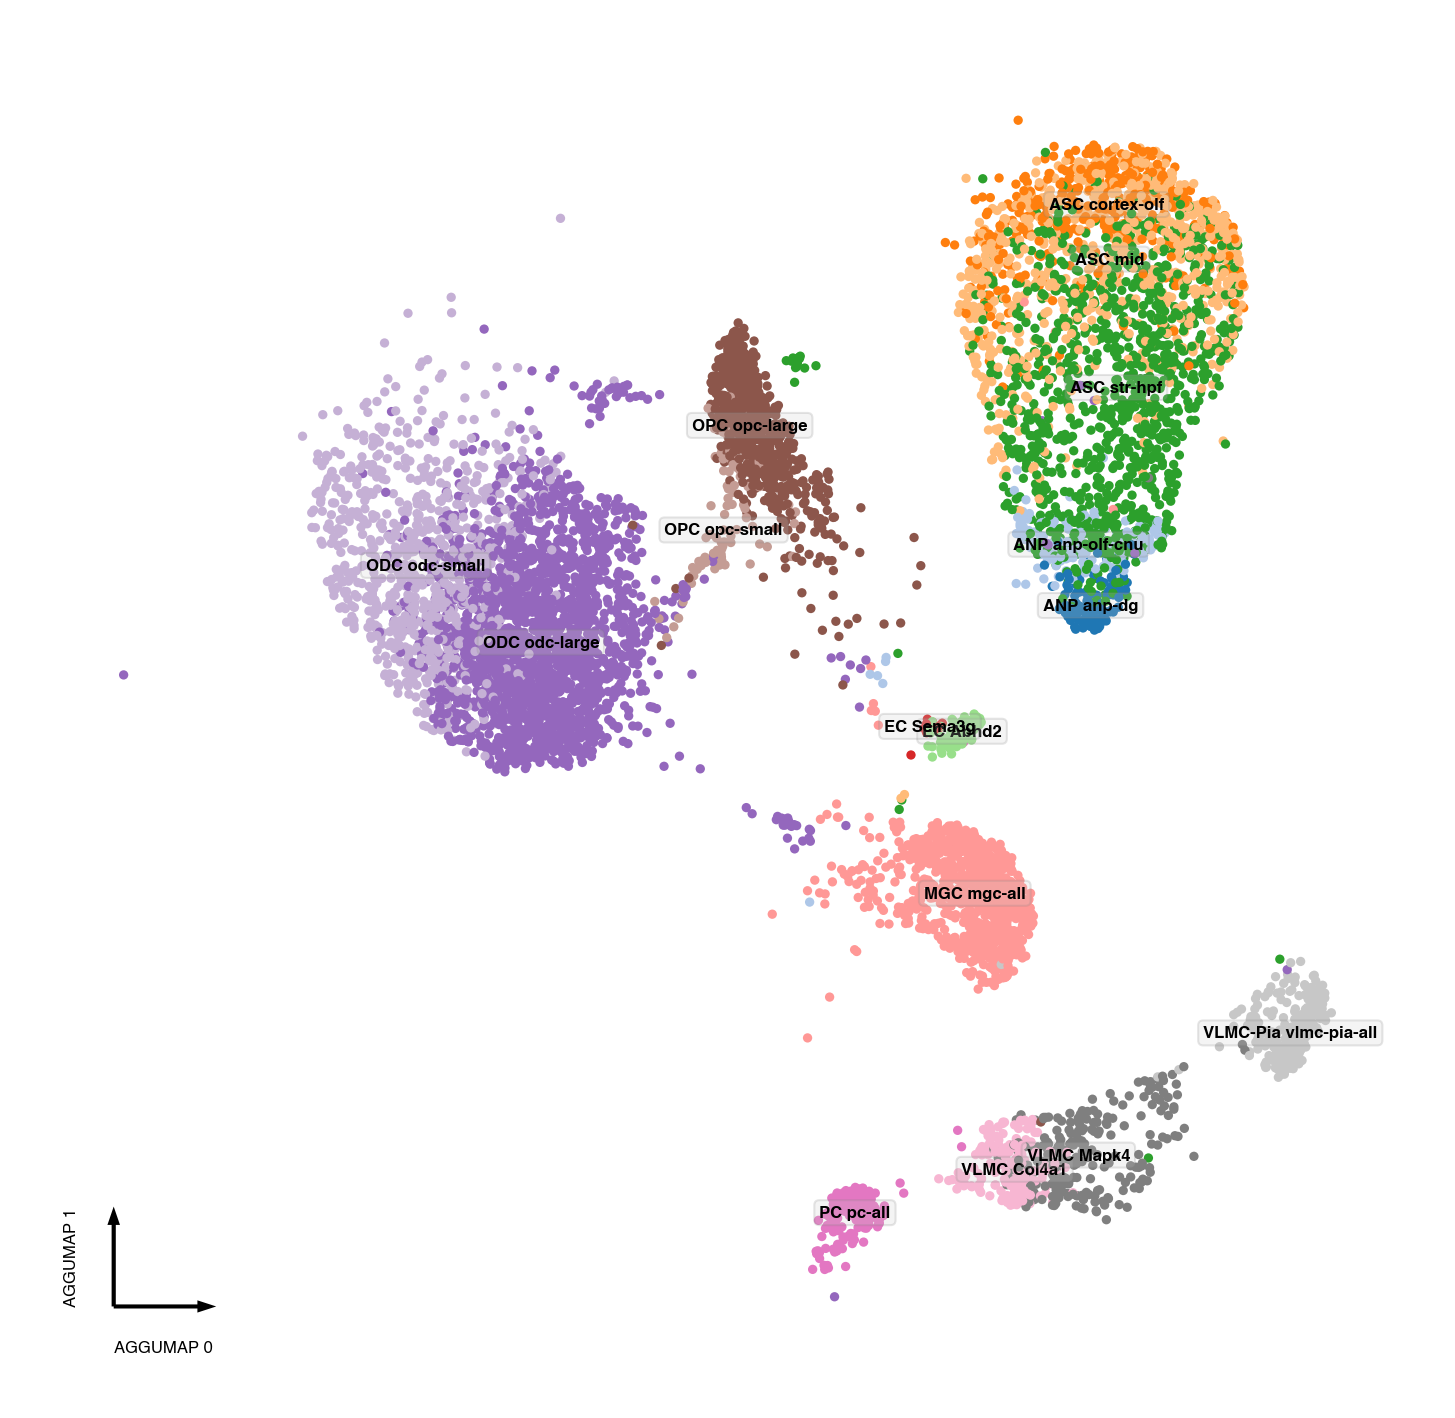

In [26]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=mc_cell_tidy_data,
                    hue='SubType',
                    coord_base='aggumap',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='SubType',
                    text_anno_kws=dict(fontsize=4))
pass

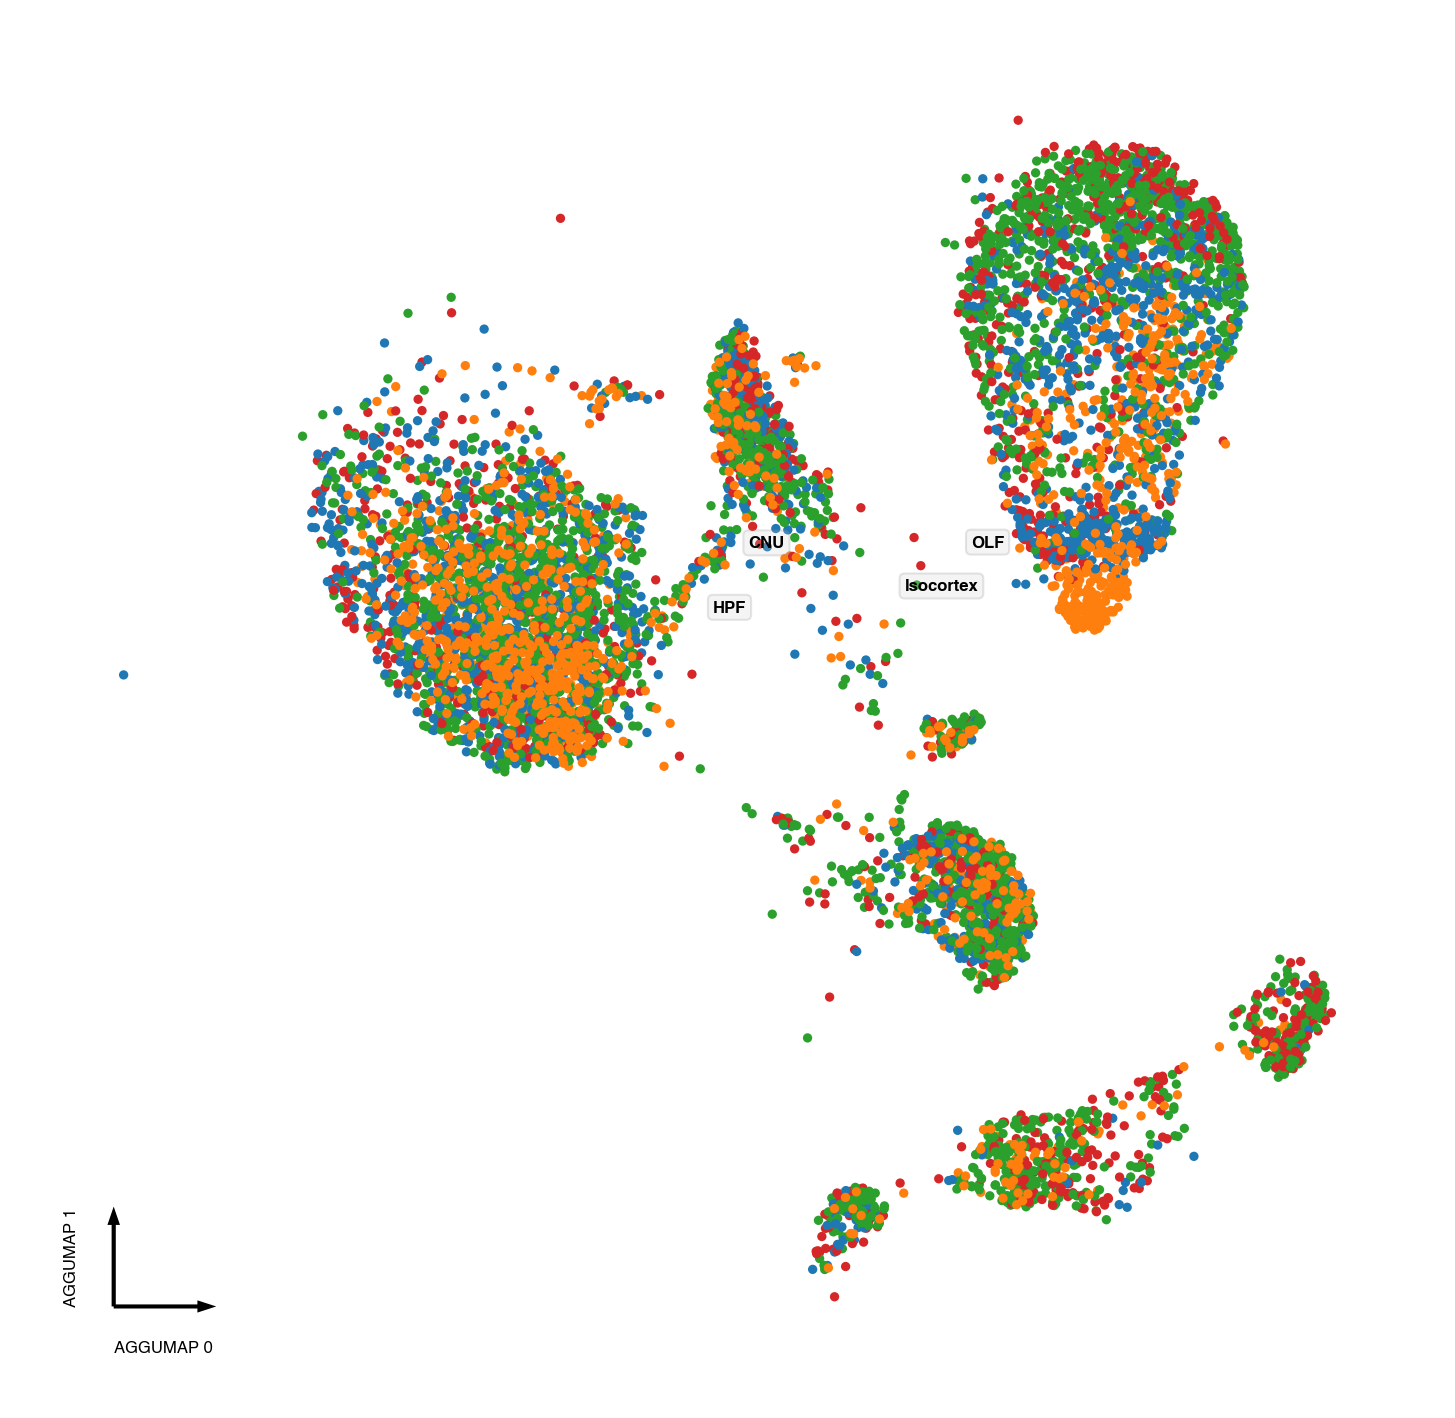

In [27]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=mc_cell_tidy_data,
                    hue='MajorRegion',
                    coord_base='aggumap',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='MajorRegion',
                    text_anno_kws=dict(fontsize=4))
pass

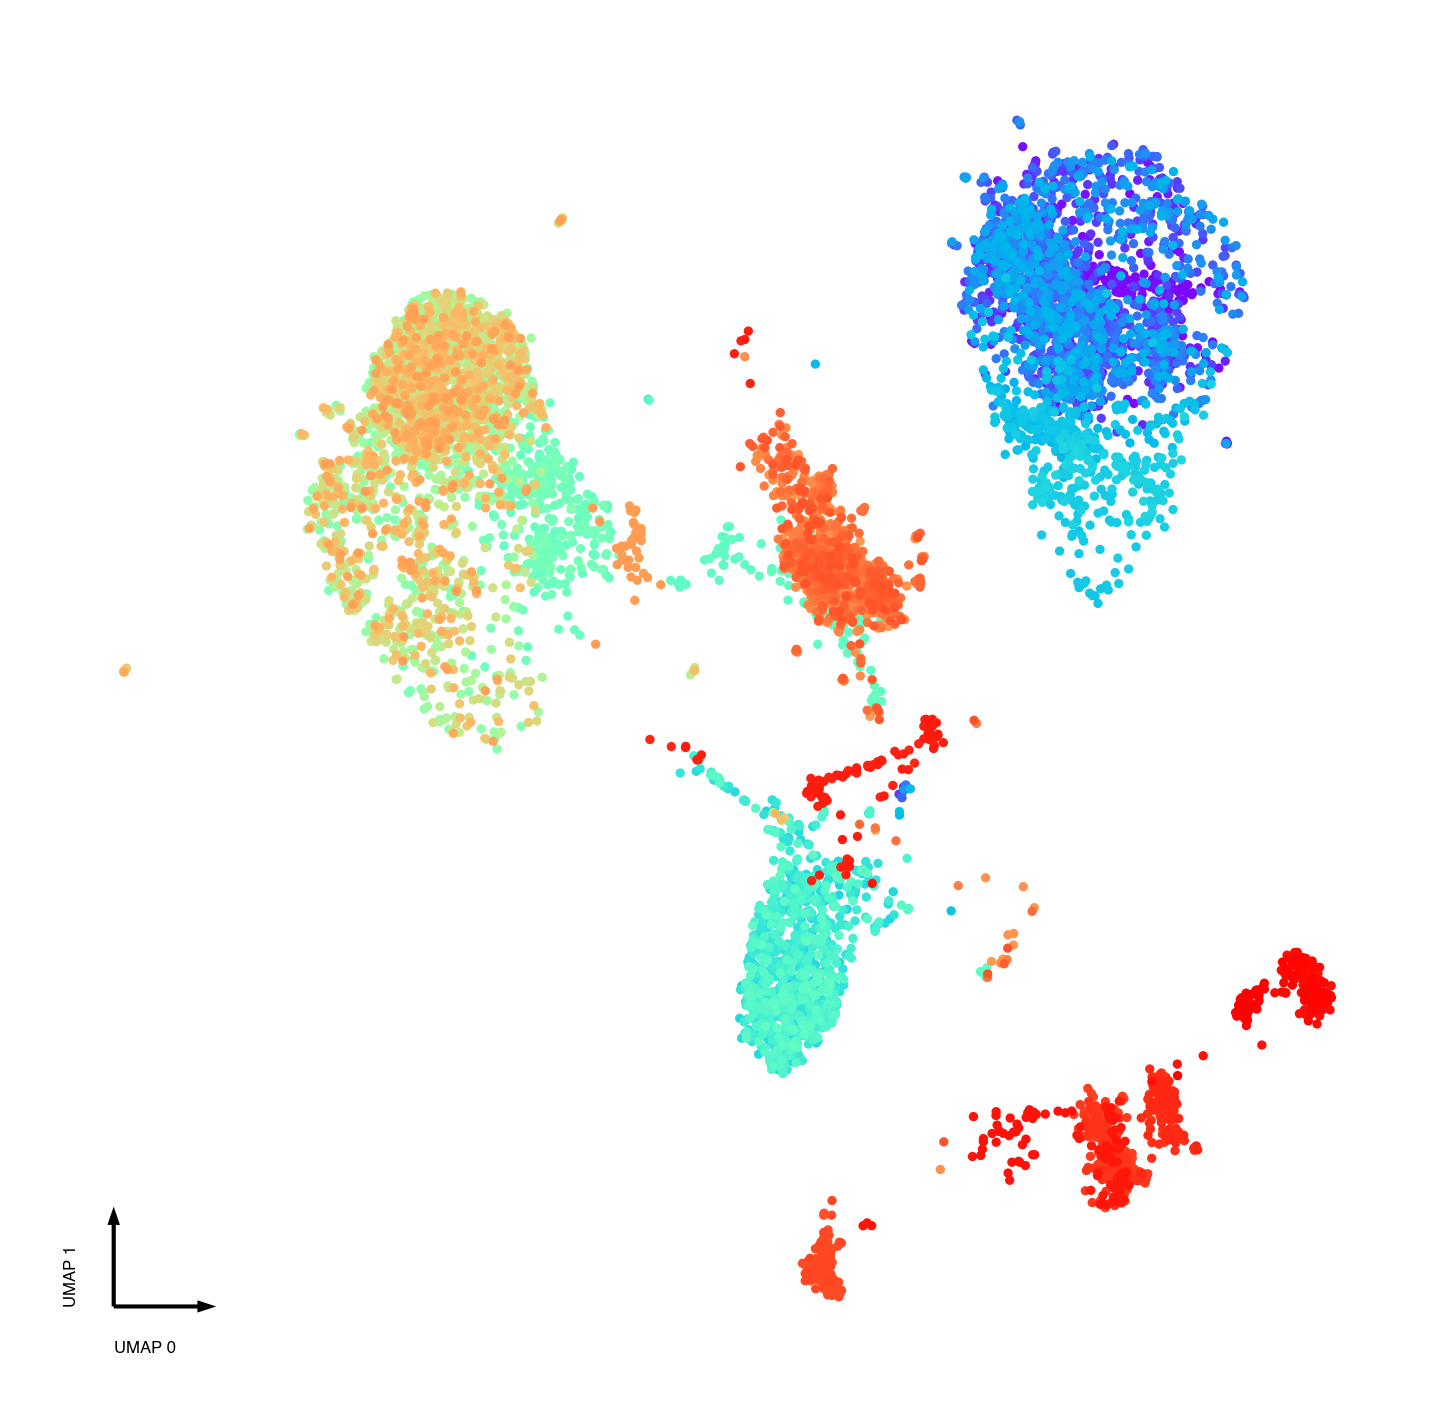

In [28]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=atac_cell_tidy_data,
                    hue='SubType',
                    coord_base='umap',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    # text_anno='SubType',
                    text_anno_kws=dict(fontsize=4))
pass

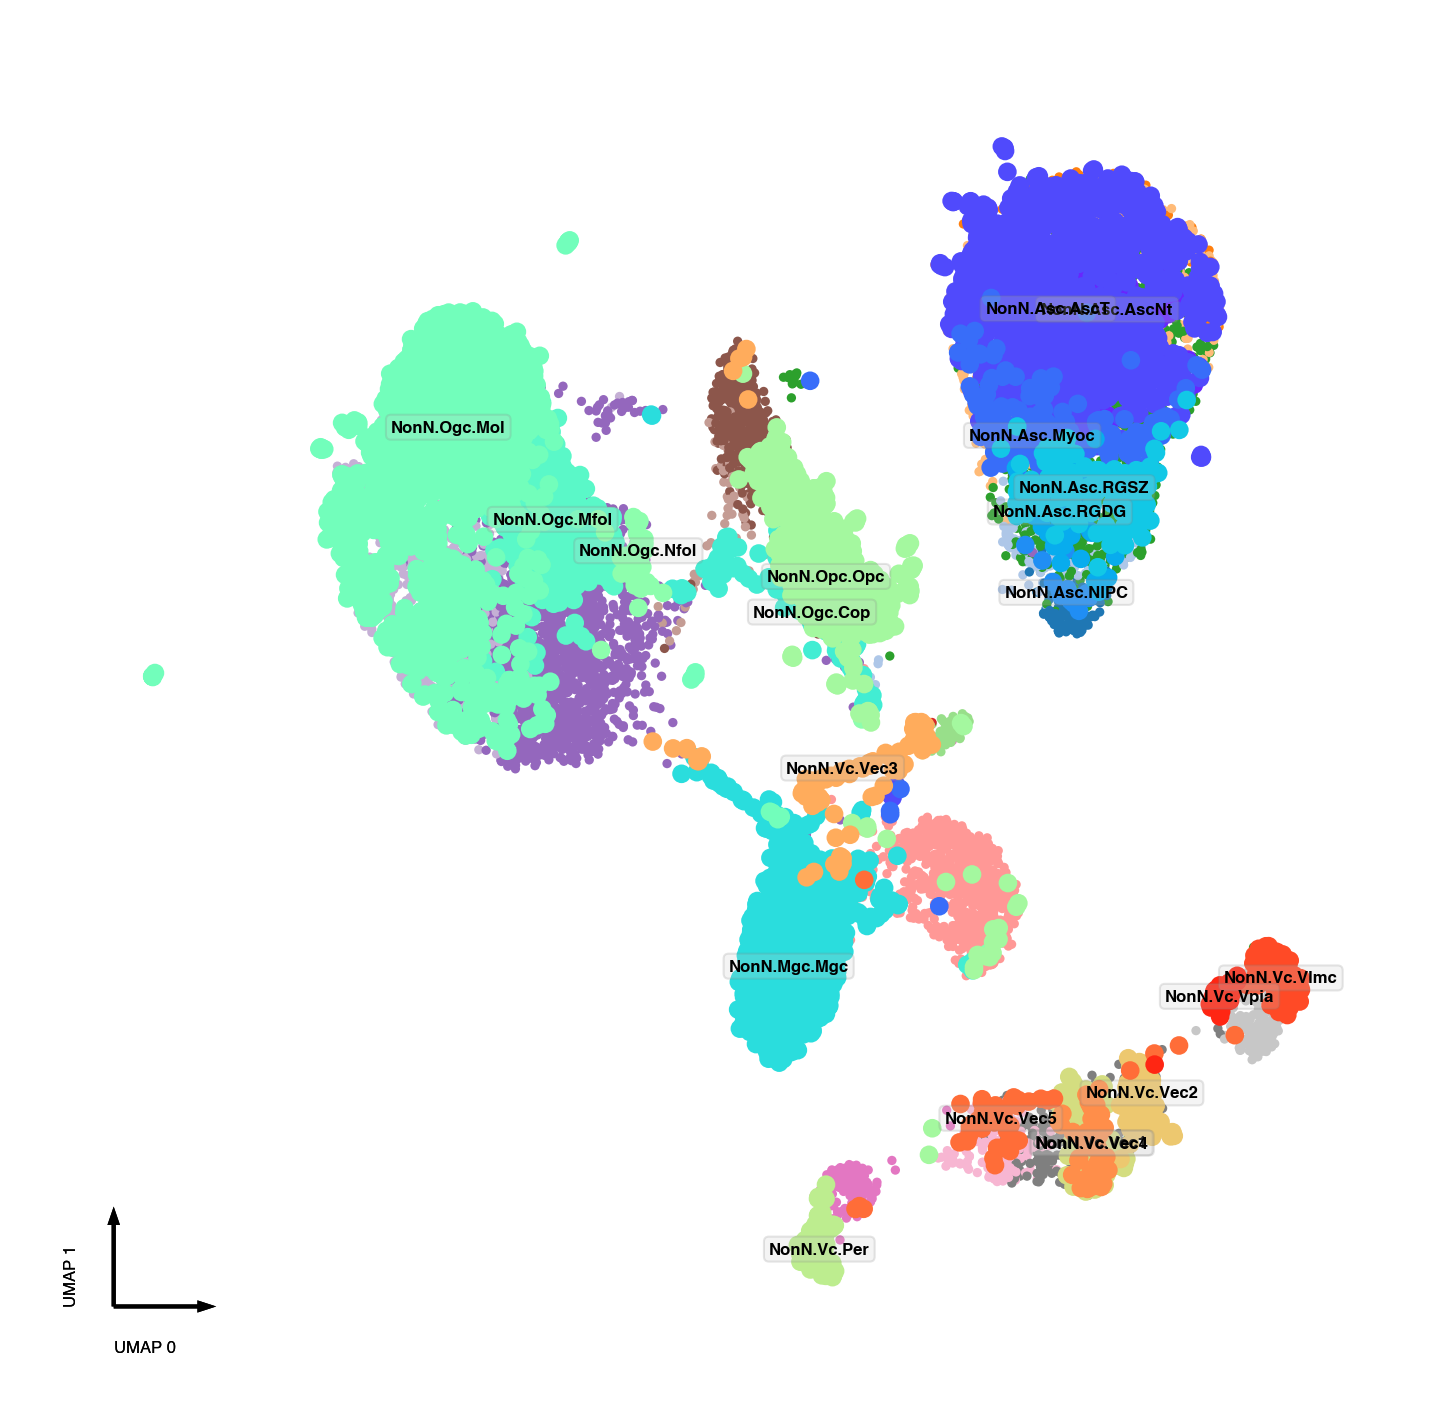

In [29]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

_this_data = cell_tidy_data[cell_tidy_data['Modality'] == 'mC'].copy()
_this_data['SubType'] = mc_cell_tidy_data['SubType']
categorical_scatter(ax=ax,
                    data=_this_data,
                    scatter_kws=dict(color='orange'),
                    hue='SubType',
                    #palette=sub_type_palette,
                    coord_base='umap',
                    max_points=None,
                    s=5)

_this_data = cell_tidy_data[cell_tidy_data['Modality'] == 'atac'].copy()
_this_data['SubType'] = atac_cell_tidy_data['SubType'].apply(lambda i: i.split('+')[0])
categorical_scatter(ax=ax,
                    data=_this_data,
                    scatter_kws=dict(color='steelblue'),
                    text_anno='SubType', 
                    hue='SubType',
                    coord_base='umap',
                    max_points=None,
                    s=20)
pass

In [30]:
atac_cell_tidy_data['SubType'] = atac_cell_tidy_data['SubType'].apply(lambda i: i.split('+')[0])

## Confusion matrix

In [31]:
cfm = calculate_direct_confusion(mc_cell_tidy_data[['SubType', 'co_cluster']], 
                                 atac_cell_tidy_data[['SubType', 'co_cluster']])

(0, 16)

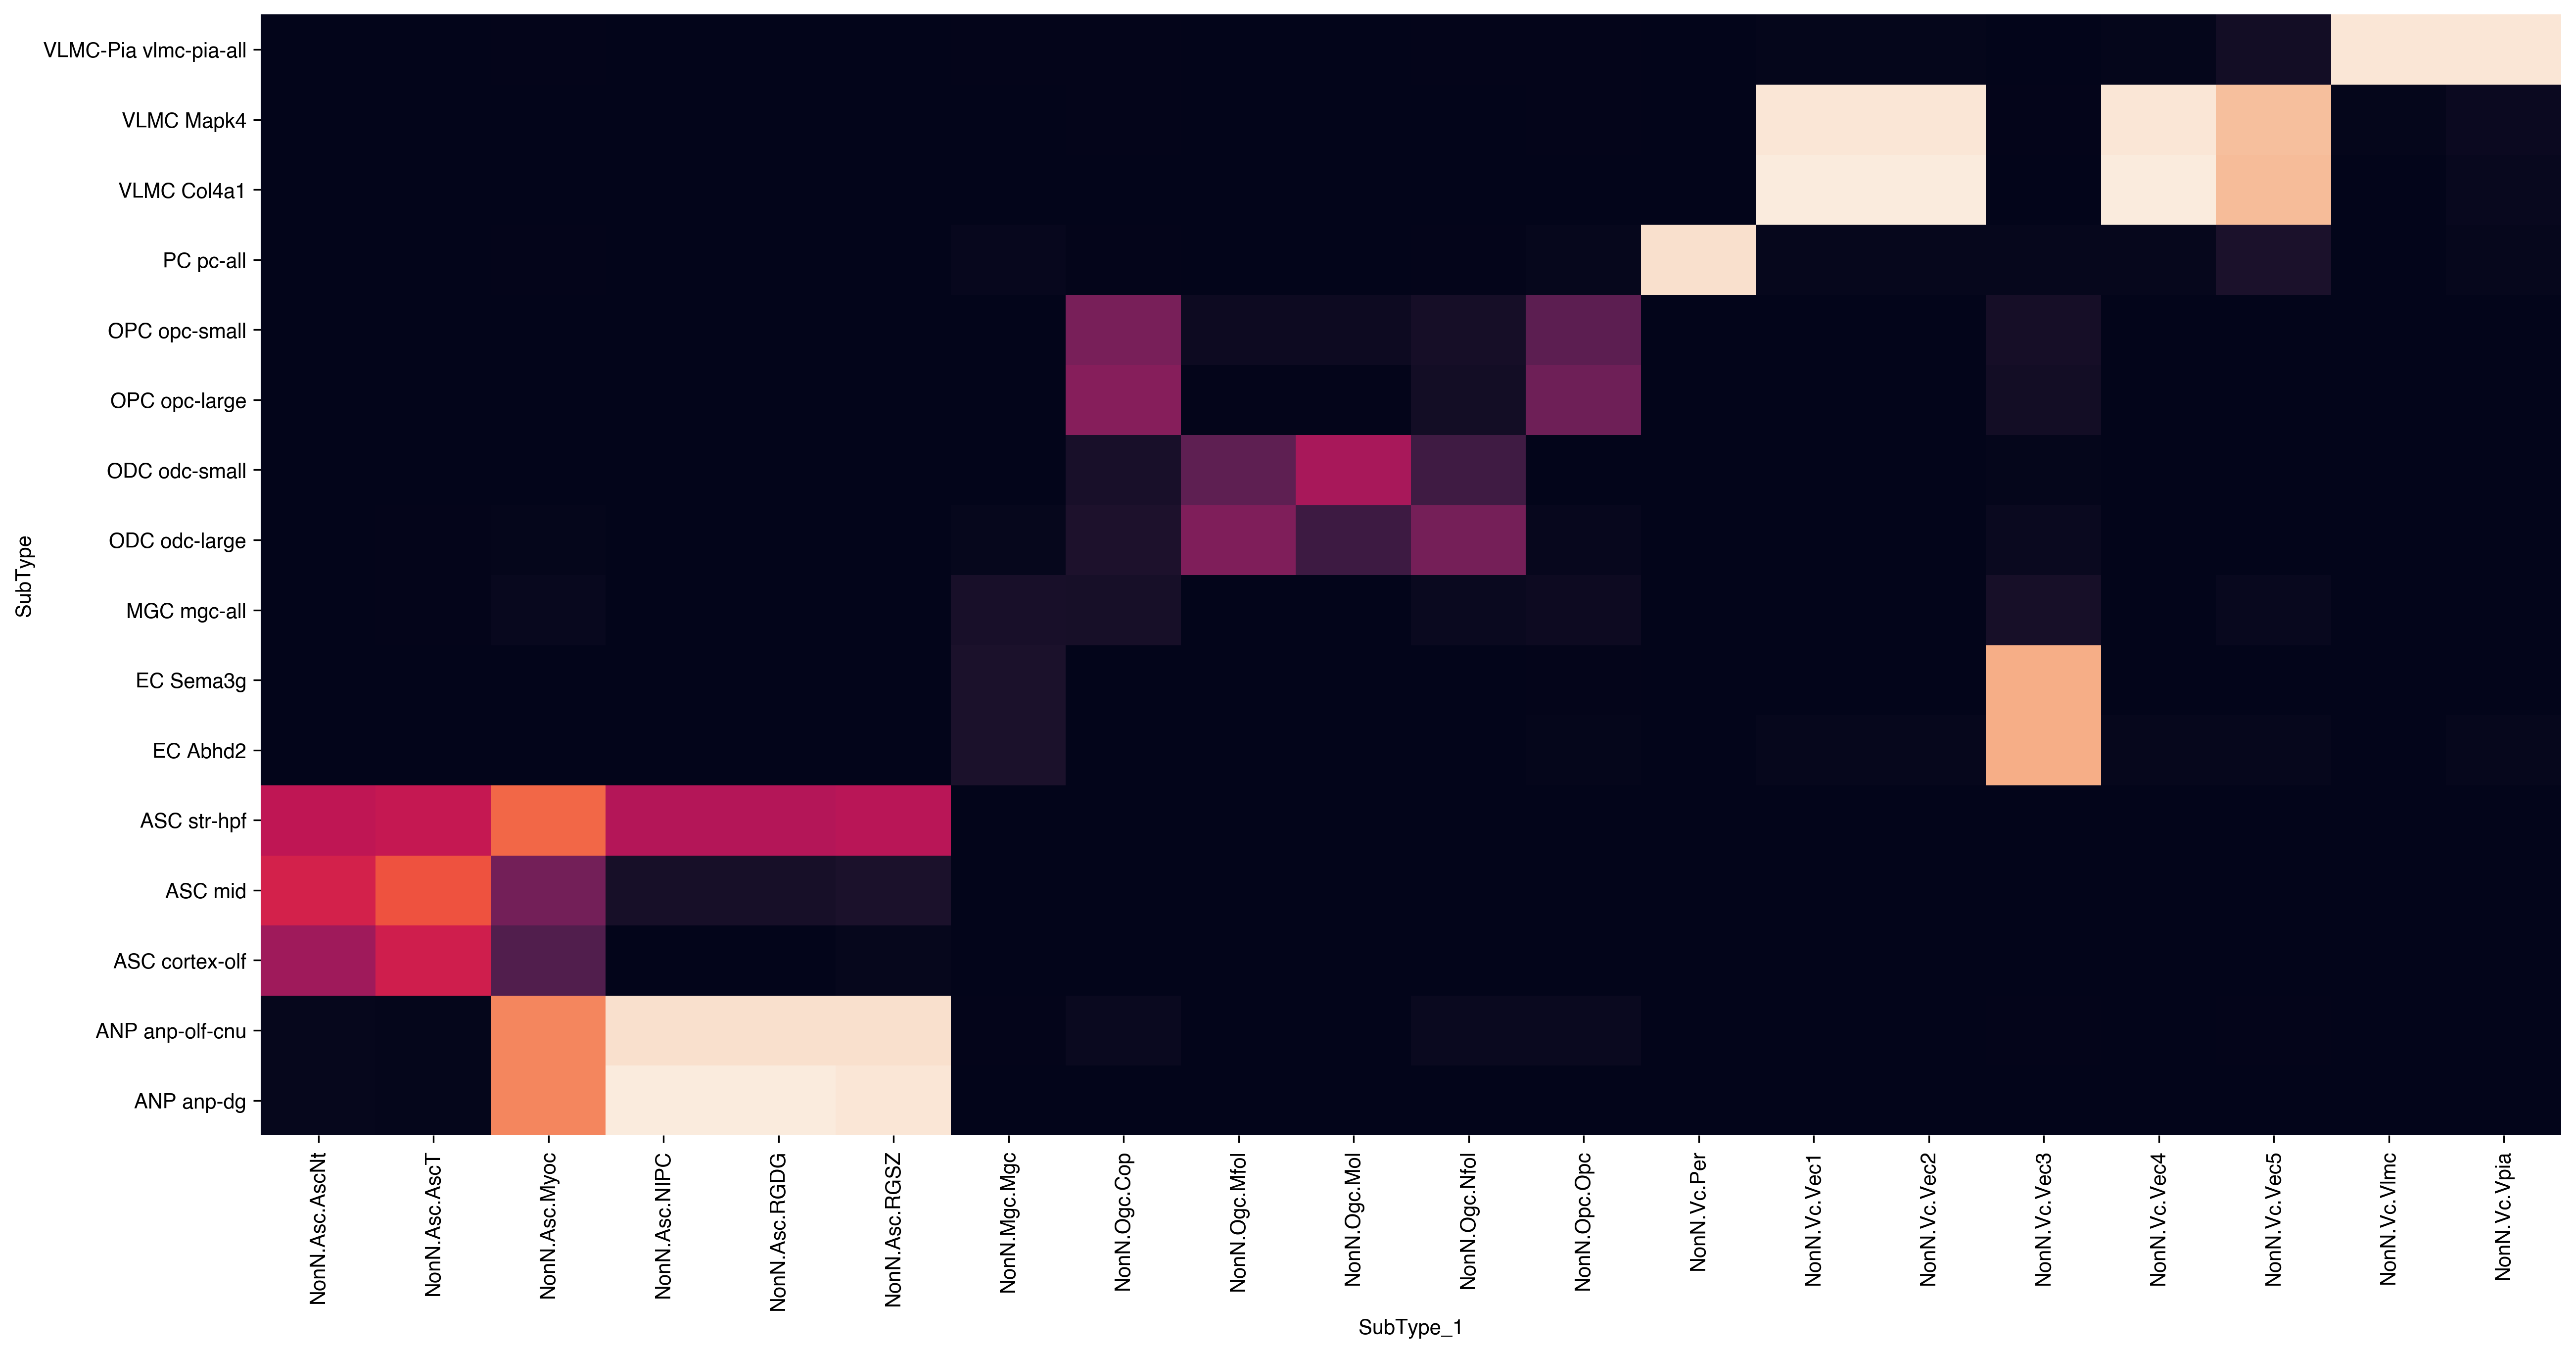

In [32]:
fig = plt.figure(figsize=(20, 10), dpi=300)

ax = sns.heatmap(cfm, cbar=None)
ax.set_ylim(0, cfm.shape[0])


## Save

In [33]:
adata.write_h5ad(output_dir / 'Integration.h5ad')

In [34]:
cell_tidy_data.to_msgpack(output_dir / 'Integration_cell_tidy_data.msg')
cell_tidy_data.head()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


,Modality,leiden,umap_0,umap_1,pca_0,pca_1,tsne_0,tsne_1
10E_M_116,mC,5,-4.228575,0.501854,0.493975,-0.157681,10.469176,25.176813
10E_M_117,mC,15,5.789691,-12.173463,-0.208078,0.471097,-29.539251,-37.784539
10E_M_118,mC,2,-1.190253,-0.406147,0.354787,0.010860,-2.201563,10.792655
10E_M_119,mC,5,-4.594005,0.042515,0.486197,-0.248451,7.726716,27.541669
10E_M_120,mC,2,-2.353158,-2.801136,0.590862,0.018029,6.765106,9.027761


In [35]:
mc_cell_tidy_data.to_msgpack(output_dir / 'mc_cell_tidy_data.with_integration_info.msg')
atac_cell_tidy_data.to_msgpack(output_dir / 'atac_cell_tidy_data.with_integration_info.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  
